### Jupyter Notebook 단축키
- ctrl+enter: 셀 실행
- shift+enter: 셀 실행 및 다음 셀 이동
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)
- esc: 셀 나가기
- m: 마크다운 셀로 바꾸기
- y: 마크다운 셀을 다시Code로 바꾸기

# *22년 01월 11일 프로그래밍 세미나 
   ** __발표자: 송승환__

## Variational AutoEncoder (VAE) & Adversarial Autoencoder (AAE)

## 2. Adversarial Autoencoder (AAE)

### What is AAE?
- AAE란 VAE에 Generative Adversarial Networks (GAN)를 사용한 구조

---

#### GAN?
![intro1](./GAN.png)


- AAE에서는 기존 VAE 구조가 기존 GAN에서의 생성자(generator) 역할을 함

- _Generator_ 의 _Encoder_ 는 데이터 $x$를 입력받아 잠재변수 $z$를 샘플링하고, 생성자의 _Decoder_ 는 이로부터 다시 $x$를 복원함

___

### AAE with GAN

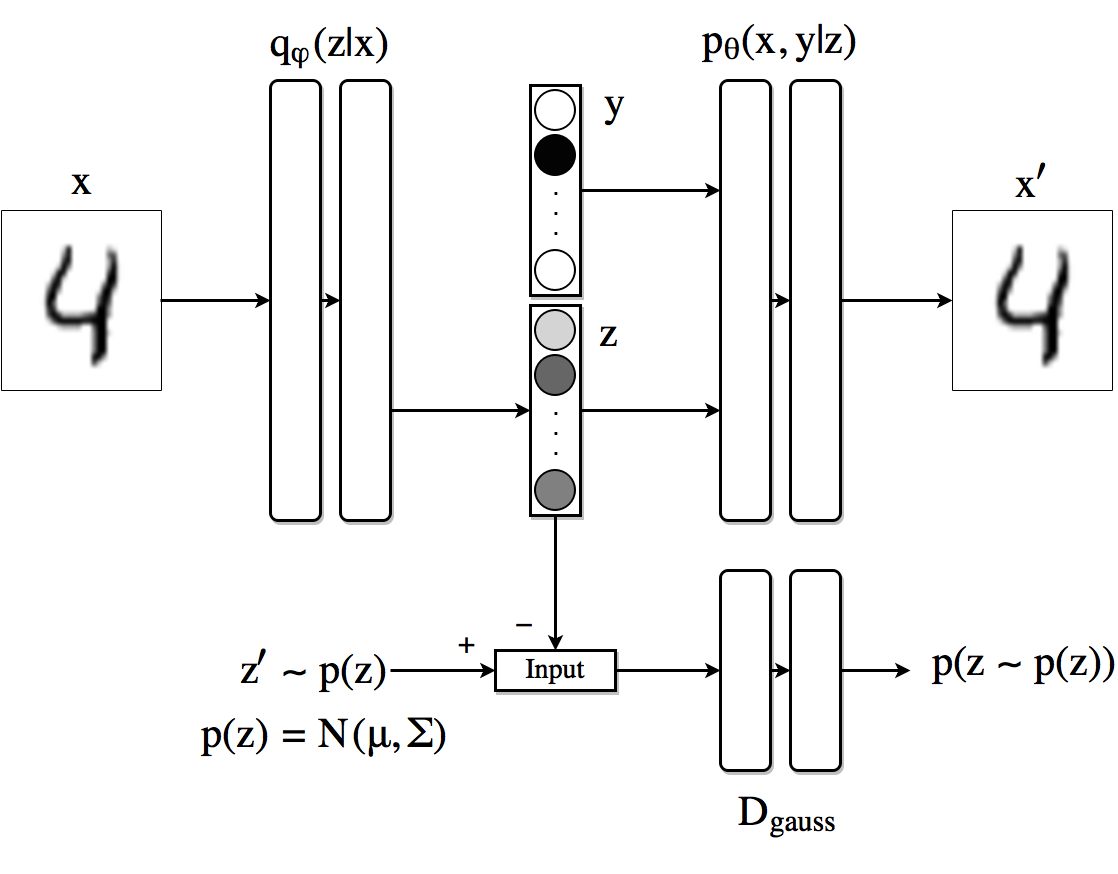

- AAE가 기존 VAE와 다른 점은 기존 GAN의 구분자(discriminator) 역할을 하는 네트워크가 추가되었다는 점임

- _Discriminator_ 는 _Generator_ 의 _Encoder_ 가 샘플링한 가짜 $z$와, $p(z)$로부터 직접 샘플링한 진짜 $z$를 구분하는 역할을 함

___

### Disadvantages of VAE
- VAE는 사전확률 분포 $p(z)$를 표준정규분포로 가정하고, $q(z|x)$를 이와 비슷하게 맞추는 과정에서 학습이 이루어짐

- 하지만, 실제 데이터 분포가 정규분포를 따르지 않거나 이보다 복잡할 경우 VAE 성능에 문제가 발생할 수 있음

---

### Overcoming with Distribution
- GAN의 경우 모델에 특정 확률분포를 전제할 필요가 없음
    - GAN은 데이터가 어떤 분포를 따르든, 데이터의 실제 분포와 생성자가 만들어내는 분포 사이의 차이를 줄이도록 학습되기 때문


- 이러한 특징을 이용한 것이 AAE의 컨셉

- VAE의 regularization term을 GAN Loss로 대체할 경우, 사전확률과 사후확률 분포를 정규분포 이외에 다른 분포를 쓸 수 있게 되므로, 모델 선택의 폭이 넓어지는 효과가 있음

---

https://github.com/yoonsanghyu/AAE-PyTorch/blob/main/aae_semi_supervised.py
### 0) 데이터 생성 Part: 모듈 불러오기

In [1]:
''' 기본 모듈 및 시각화 모듈 '''
from __future__ import print_function
from IPython.display import Image

''' PyTorch 사용을 위한 모듈 '''
import pickle
import numpy as np
import torch
from torchvision import datasets, transforms

''' subMNIST 사용을 위한 모듈 '''
from sub import subMNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\subMNIST\raw\train-images-idx3-ubyte.gz to data\subMNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\subMNIST\raw\train-labels-idx1-ubyte.gz to data\subMNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\subMNIST\raw\t10k-images-idx3-ubyte.gz to data\subMNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\subMNIST\raw\t10k-labels-idx1-ubyte.gz to data\subMNIST\raw



C:\Users\seunghwan\.conda\envs\env1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
''' 데이터 전처리 '''
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset_original = datasets.MNIST('data', train=True, download=True,
                                   transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



### 0) 데이터 생성 Part: 데이터 분할 및 저장

In [3]:
''' train/validation 분할 '''
train_label_index = []
valid_label_index = []
for i in range(10):
    train_label_list = trainset_original.train_labels.numpy()
    label_index = np.where(train_label_list == i)[0]
    label_subindex = list(label_index[:300])
    valid_subindex = list(label_index[300: 1000 + 300])
    train_label_index += label_subindex
    valid_label_index += valid_subindex
    
''' train dataset(labeled) dataset 저장 '''
trainset_np = trainset_original.train_data.numpy()
trainset_label_np = trainset_original.train_labels.numpy()
train_data_sub = torch.from_numpy(trainset_np[train_label_index])
train_labels_sub = torch.from_numpy(trainset_label_np[train_label_index])

trainset_new = subMNIST(root='data', train=True, download=True, transform=transform, k=3000)
trainset_new.data = train_data_sub.clone()
trainset_new.targets = train_labels_sub.clone()

pickle.dump(trainset_new, open("data/train_labeled.p", "wb"))

''' validataion dataset 저장 '''
validset_np = trainset_original.train_data.numpy()
validset_label_np = trainset_original.train_labels.numpy()
valid_data_sub = torch.from_numpy(validset_np[valid_label_index])
valid_labels_sub = torch.from_numpy(validset_label_np[valid_label_index])


validset = subMNIST(root='data', train=False, download=True, transform=transform, k=10000)
validset.data = valid_data_sub.clone()
validset.targets = valid_labels_sub.clone()

pickle.dump(validset, open("data/validation.p", "wb"))

C:\Users\seunghwan\.conda\envs\env1\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\seunghwan\.conda\envs\env1\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
''' train dataset(unlabeled) dataset 저장 '''
train_unlabel_index = []
for i in range(60000):
    if i in train_label_index or i in valid_label_index:
        pass
    else:
        train_unlabel_index.append(i)

trainset_np = trainset_original.train_data.numpy()
trainset_label_np = trainset_original.train_labels.numpy()
train_data_sub_unl = torch.from_numpy(trainset_np[train_unlabel_index])
train_labels_sub_unl = torch.from_numpy(trainset_label_np[train_unlabel_index])

trainset_new_unl = subMNIST(root='data', train=True, download=True, transform=transform, k=47000)
trainset_new_unl.data = train_data_sub_unl.clone()
trainset_new_unl.targets = None      # Unlabeled

trainset_new_unl.targets

pickle.dump(trainset_new_unl, open("data/train_unlabeled.p", "wb"))

### 1) 모듈 불러오기

In [5]:
''' 기본 모듈 및 시각화 모듈 '''
import easydict #import argparse 대체로 사용
import numpy as np 
import math
import itertools
import os

''' PyTorch 사용을 위한 모듈 '''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision import datasets

''' Pickle data load를 위한 모듈 '''
from img_dataloader import load_data

### 2) Hyperparameter 설정

In [6]:
args = easydict.EasyDict({
    "batch_size": 64,
    "epochs": 500,
    "no_cuda": False,
    "seed": 10,
    "lr": 0.0002, #learning rate
    "b1": 0.5, #decay of first order momentum of gradient, 
    "b2": 0.999, #decay of first order momentum of gradient
    "latent_dim": 10,
    "img_size": 32, #sub.py에서 이미지를 32X32로 resize
    "channels": 1,
    
    "img_dir": 'image_basic'#이미지 경로 폴더명
})

In [7]:
''' cuda 사용 '''
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

# config cuda
img_shape = (args.channels, args.img_size, args.img_size)
Tensor = torch.cuda.FloatTensor if args.cuda else torch.FloatTensor

### 3) AAE Architecture
![intro2](./AAE.png)

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ''' 32X32 이미지를 일자로 펴서 1024 크기 vector로 만듦 '''
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, args.latent_dim)
        )
        ''' 
        Encoder: 1024-D vector가 input으로 들어와서 512-D hidden layer를 통과 (relu)
        이후 512개의 분포에 대한 mean과 variance를 내보냄
        '''
        self.mu = nn.Linear(512, args.latent_dim)
        self.logvar = nn.Linear(512, args.latent_dim)

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        x = self.model(img_flat)
        # mu = self.mu(x)
        # logvar = self.logvar(x)
        # z = reparameterization(mu, logvar)
        return x

    
''' 
Decoder: latent 값으로부터 data에 대한 Bernoulli distribution을 출력
Bernoulli 분포는 0에서 1 사이이므로 sigmoid 함수를 output layer의 activation function으로 사용
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(args.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.shape[0], *img_shape)
        return img

''' 
Discriminator: prior에서 생성한 값에 대해 training data와 유사하게 만듦
'''
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(args.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

### 4) Preparation part
### 모델 및 손실 함수, Optimizer 설정

In [9]:
''' 데이터 load '''
train_labeled_loader = load_data('data/')[1]

''' 모델 정의 '''
# 1) generator
encoder = Encoder()
decoder = Decoder()
# 2) discriminator
discriminator = Discriminator()

# loss
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

# optimizer
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))

if args.cuda:
    encoder.to(device)
    decoder.to(device)
    discriminator.to(device)
    adversarial_loss.to(device)
    reconstruction_loss.to(device)

loading data!


### 5) Train & Evaluate AAE

In [10]:
''' 이미지 저장 모듈'''
def sample_image(n_row, epoch, img_dir):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    z = Variable(Tensor(np.random.normal(0,1,(n_row**2, args.latent_dim))))
    generated_imgs = decoder(z)
    save_image(generated_imgs.data, os.path.join(img_dir, "%depoch.png" % epoch), nrow = n_row, normalize = True)

In [11]:
for epoch in range(args.epochs):
    for i, (x, idx) in enumerate(train_labeled_loader):

        valid = Variable(Tensor(x.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(x.shape[0], 1).fill_(0.0), requires_grad=False)
        
        if args.cuda:
            x = x.to(device)
        
        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        fake_z = encoder(x)
        decoded_x = decoder(fake_z)
        validity_fake_z = discriminator(fake_z)
        G_loss = 0.001*adversarial_loss(validity_fake_z, valid) + 0.999*reconstruction_loss(decoded_x, x)
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = Variable(Tensor(np.random.normal(0,1,(x.shape[0], args.latent_dim))))
        real_loss = adversarial_loss(discriminator(real_z), valid)
        fake_loss = adversarial_loss(discriminator(fake_z.detach()), fake)
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()

    # print loss
    print(
            "[Epoch %d/%d] [G loss: %f] [D loss: %f]"
            % (epoch, args.epochs, G_loss.item(), D_loss.item())
         )
        
    sample_image(n_row = 10, epoch=epoch, img_dir=args.img_dir)

[Epoch 0/500] [G loss: 0.079732] [D loss: 0.533485]
[Epoch 1/500] [G loss: 0.062876] [D loss: 0.526991]
[Epoch 2/500] [G loss: 0.066269] [D loss: 0.524464]
[Epoch 3/500] [G loss: 0.061590] [D loss: 0.359853]
[Epoch 4/500] [G loss: 0.048943] [D loss: 0.434631]
[Epoch 5/500] [G loss: 0.063477] [D loss: 0.399598]
[Epoch 6/500] [G loss: 0.048558] [D loss: 0.363774]
[Epoch 7/500] [G loss: 0.071471] [D loss: 0.403915]
[Epoch 8/500] [G loss: 0.066597] [D loss: 0.526277]
[Epoch 9/500] [G loss: 0.056175] [D loss: 0.435181]
[Epoch 10/500] [G loss: 0.048959] [D loss: 0.514014]
[Epoch 11/500] [G loss: 0.053312] [D loss: 0.506340]
[Epoch 12/500] [G loss: 0.065580] [D loss: 0.500907]
[Epoch 13/500] [G loss: 0.045411] [D loss: 0.376884]
[Epoch 14/500] [G loss: 0.047070] [D loss: 0.430587]
[Epoch 15/500] [G loss: 0.045696] [D loss: 0.402425]
[Epoch 16/500] [G loss: 0.072428] [D loss: 0.427648]
[Epoch 17/500] [G loss: 0.048464] [D loss: 0.435114]
[Epoch 18/500] [G loss: 0.046214] [D loss: 0.485324]
[Ep

# EOD